# 사무유형구분_Random Forest

## 0. 라이브러리 및 데이터 불러오기

### 폰트설정

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,326 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120903 files and dire

In [ ]:
import  matplotlib
import  matplotlib.font_manager  as fm
import  matplotlib.pyplot  as plt


print('◎ matplotlib version : ', matplotlib.__version__)
print()


sys_font  = fm.findSystemFonts ( )

[ font  for  font  in  sys_font  if  "Nanum"  in font ]

◎ matplotlib version :  3.7.1



['/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf']

In [ ]:
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

### 라이브러리 및 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/KPMG 캡스톤/사무총조사/filter_df.csv')

In [ ]:
with open("/content/drive/MyDrive/KPMG 캡스톤/사무총조사/수행주체/subject_list.pkl","rb") as f:
    subject_list = pickle.load(f)

In [ ]:
# df_1: 사무판단 == 1인 행들만 있는 dataframe
df_1 = df[df['사무판단'] == 1]

In [ ]:
df_1['사무유형(대분류)'] = np.nan

scale_n = ['국가직접처리사무', '특별지방행정기관사무', '국가위탁사무', '시도위임사무', '시군구위임사무', '시군구재위임사무', '시도및시군구위임사무']
scale_p = ['국가-시도-시군구공동사무', '국가-시도공동사무', '국가-시군구공동사무']
scale_r = ['시도직접처리사무', '시도위탁사무', '시군구직접처리사무', '시군구위탁사무', '시도-시군구공동사무', '시도-시군구위임사무']

for ii in range(len(df_1)):
  minitask = str(df_1.iloc[ii,24])
  if minitask == 'nan':
    df_1.iloc[ii,28] = '0'
  elif minitask in scale_n:
    df_1.iloc[ii,28] = '국가'
  elif minitask in scale_p:
    df_1.iloc[ii,28] = '공동'
  elif minitask in scale_r:
    df_1.iloc[ii,28] = '지방'

In [ ]:
# '조문' string으로 바꾸기
# df_1 속 '조문'이 결측치인 행 2개 존재
df_1['조문'] = df_1['조문'].apply(lambda x: '' if pd.isna(x) else str(x))

<ipython-input-7-fb36dbb56b2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['조문'] = df_1['조문'].apply(lambda x: '' if pd.isna(x) else str(x))


## 1. column들 생성

### 1st column 생성: 가장 많이 들어있는 수행주체 index 2~3개 추출
- 수행주체_freq1: 가장 많이 들어있는 수행주체 index
- 수행주체_freq2: 두 번째로 많이 들어있는 수행주체 index
- 수행주체_freq3: 세 번째로 많이 들어있는 수행주체 index

In [ ]:
df_1.columns

Index(['Unnamed: 0', '소관부처명', '법령명', '법령구분', '조번호', '항번호', '호번호', '조문제목', '조문',
       '사무판단', '사무판단근거', '사무명', '수행주체', '사무유형', '위임사무판단', '위임근거규정', '수임기관',
       '특행기관', '재위임사무판단', '재위임근거규정', '재수임기관', '위탁사무판단', '위탁근거규정', '수탁기관',
       '사무유형(소분류)', '기타', '조문_명_동', 'new_수행주체', '사무유형(대분류)', '수행주체_freq1',
       '수행주체_freq2', '수행주체_freq3', '수행주체_국가', '수행주체_지방', '수행주체_공동',
       '수행주체_국가_교', '수행주체_지방_교', '수행주체_공동_교'],
      dtype='object')

In [ ]:
df_1['new_수행주체'] = df_1['new_수행주체'].apply(lambda x: '' if pd.isna(x) else str(x))

word_vec = []
for item in df_1['new_수행주체']:
    row_vec = [0] * len(subject_list)
    for subject in subject_list:
        count = item.count(subject)
        if count > 0:
            index = subject_list.index(subject)
            row_vec[index] += count
    word_vec.append(row_vec)

<ipython-input-8-418e96bc39fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['new_수행주체'] = df_1['new_수행주체'].apply(lambda x: '' if pd.isna(x) else str(x))


In [ ]:
word_vec = pd.DataFrame(word_vec)

In [ ]:
def get_nlargest_index(row, n):
    if row.nlargest(n).iloc[-1] == 0:
        return np.nan
    else:
        return row.nlargest(n).index[-1]

# 각 열에 대한 값을 계산하고 NaN 조건을 적용합니다.
df_1['수행주체_freq1'] = word_vec.apply(lambda row: np.nan if row.max() == 0 else row.idxmax(), axis=1)
df_1['수행주체_freq2'] = word_vec.apply(lambda row: get_nlargest_index(row, 2), axis=1)
df_1['수행주체_freq3'] = word_vec.apply(lambda row: get_nlargest_index(row, 3), axis=1)

<ipython-input-10-6c8980145691>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['수행주체_freq1'] = word_vec.apply(lambda row: np.nan if row.max() == 0 else row.idxmax(), axis=1)
<ipython-input-10-6c8980145691>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['수행주체_freq2'] = word_vec.apply(lambda row: get_nlargest_index(row, 2), axis=1)
<ipython-input-10-6c8980145691>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [ ]:
# NaN값에는 그냥 2000 넣어줌, 자료형 int로 바꿔줌

df_1[['수행주체_freq1', '수행주체_freq2', '수행주체_freq3']] = df_1[['수행주체_freq1', '수행주체_freq2', '수행주체_freq3']].fillna(2000)
df_1 = df_1.astype({'수행주체_freq1': 'int', '수행주체_freq2': 'int', '수행주체_freq3': 'int'})

<ipython-input-11-4095259a2aac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[['수행주체_freq1', '수행주체_freq2', '수행주체_freq3']] = df_1[['수행주체_freq1', '수행주체_freq2', '수행주체_freq3']].fillna(2000)


### 2nd column 생성: '국가', '지방', '공동'에 들어있는 수행주체 구분하기
- 수행주체_국가: '국가사무'에만 존재하는 수행주체가 '조문'에서 언급된 횟수
- 수행주체_지방: '지방사무'에만 존재하는 수행주체가 '조문'에서 언급된 횟수
- 수행주체_공동: '공동사무'에만 존재하는 수행주체가 '조문'에서 언급된 횟수
---
- 수행주체_국가_교: '국가사무'에 존재하는 수행주체가 '조문'에서 언급된 횟수
- 수행주체_지방_교: '지방사무'에 존재하는 수행주체가 '조문'에서 언급된 횟수
- 수행주체_공동_교: '공동사무'에 존재하는 수행주체가 '조문'에서 언급된 횟수

In [ ]:
df_country = df_1[df_1['사무유형(대분류)'] == '국가']
df_province = df_1[df_1['사무유형(대분류)'] == '지방']
df_both = df_1[df_1['사무유형(대분류)'] == '공동']

In [ ]:
# 국가사무, 지방사무, 공동사무 각각의 조문에 언급된 수행주체 뽑아내기

# 국가사무 '조문'에 들어있는 수행주체
subject_country = []
for subject in subject_list:
  if df_country['조문'].str.contains(subject).any():
    subject_country.append(subject)

# 지방사무 '조문'에 들어있는 수행주체
subject_province = []
for subject in subject_list:
  if df_province['조문'].str.contains(subject).any():
    subject_province.append(subject)

# 공동사무 '조문'에 들어있는 수행주체
subject_both = []
for subject in subject_list:
  if df_both['조문'].str.contains(subject).any():
    subject_both.append(subject)

In [ ]:
set_country = set(subject_country)
set_province = set(subject_province)
set_both = set(subject_both)

# 국가, 지방, 공동사무 모두에 존재하는 수행주체
common_elements = set_country.intersection(set_province).intersection(set_both)

# 국가사무에만 존재하는 수행주체
unique_country = set_country - set_province - set_both

# 지방사무에만 존재하는 수행주체
unique_province = set_province - set_country - set_both

# 공동사무에만 존재하는 수행주체
unique_both = set_both - set_country - set_province

# 결과 출력
print('==================')
print("국가, 지방, 공동 모두 존재")
print("주체:", common_elements)
print("개수:",len(common_elements))
print('==================')
print("국가사무에만 존재")
print("주체:", unique_country)
print("개수:",len(unique_country))
print('==================')
print("지방사무에만 존재")
print("주체:", unique_province)
print("개수:",len(unique_province))
print('==================')
print("공동사무에만 존재")
print("주체:", unique_both)
print("개수:",len(unique_both))
print('==================')

국가, 지방, 공동 모두 존재
주체: {'기업체', '지방의회', '통계청', '특별시', '지방국세청', '행정관청', '청장', '산림조합중앙회', '소장', '자산관리공사', '신청인', '행정청', '실무위원회', '주무부처', '재단', '외국환은행', '정부', '사법경찰관', '하고자 하는 자', '물품관리관', '지방식품의약품안전청장', '식물검역기관', '추천위원회', '국장', '직업교육훈련기관', '지방환경청', '은행', '광역지방자치단체', '수산청', '보훈병원', '호의 기관', '중앙행정기관', '사범대학', '검역기관', '유치원', '국민안전처장관', '해양경찰청', '허가관청', '수면관리자', '공원관리청', '사업계획승인권자', '요구권자', '지방공기업', '관리권자', '국가기관', '대통령령으로 정하는 공공기관', '간사', '자치구', '감사', '노동부장관', '교육단체', '한국토지주택공사', '궤도사업자', '임용권자', '피해아동', '지역군사령관', '변호사', '소방청', '원자력안전위원회', '한국환경공단', '발주청', '특허청', '사업단', '법무부', '이전공공기관', '수익자', '재난관리책임기관', '관측기관', '자치구구청장', '학교', '지방토지수용위원회', '신고한 자', '도의회', '개발원', '신용카드업자', '보호기관', '중앙대책본부장', '통일부', '위원장', '대통령', '댐건설사업시행자', '군인', '금융기관', '지역자활센터', '처장', '시ㆍ군', '영사', '시행자', '하천관리청', '지방도로관리청', '한국보훈복지의료공단', '중앙회', '단체', '구조ㆍ구급대원', '공공단체', '국가유공자', '농림축산식품부', '시ㆍ군ㆍ자치구', '손실을 입은 자', '관장', '사업시행자', '진흥원', '국가기술표준원', '건강보험공단', '시·구', '심판원', '보장기관', '지방병무청', '관리', '법원', '납세의무자', '국무총리', '수사기관', '사업

In [ ]:
# '국가'사무에만 존재하는 수행주체
df_1['수행주체_국가'] = df_1['조문'].apply(lambda x: sum(word in x for word in unique_country))
# '지방' 사무에만 존재하는 수행주체
df_1['수행주체_지방'] = df_1['조문'].apply(lambda x: sum(word in x for word in unique_province))
# '공동' 사무에만 존재하는 수행주체
df_1['수행주체_공동'] = df_1['조문'].apply(lambda x: sum(word in x for word in unique_both))

In [ ]:
# '국가' 사무에 들어있는 모든 수행주체
df_1['수행주체_국가_교'] = df_1['조문'].apply(lambda x: sum(word in x for word in set_country))
# '지방' 사무에 들어있는 모든 수행주체
df_1['수행주체_지방_교'] = df_1['조문'].apply(lambda x: sum(word in x for word in set_province))
# '공동' 사무에 들어있는 모든 수행주체
df_1['수행주체_공동_교'] = df_1['조문'].apply(lambda x: sum(word in x for word in set_both))

In [ ]:
df_1[['수행주체_국가_교', '수행주체_지방_교', '수행주체_공동_교']].sum()

수행주체_국가_교    230786
수행주체_지방_교    224007
수행주체_공동_교    224662
dtype: int64

### 3rd column 생성
- '수행주체_국가n': 행별로 'new_수행주체'가 '국가사무'에서 언급된 횟수 sum
- '수행주체_지방n': 행별로 'new_수행주체'가 '지방사무'에서 언급된 횟수 sum
- '수행주체_공동n': 행별로 'new_수행주체'가 '공동사무'에서 언급된 횟수 sum

In [ ]:
# subject_dic 만들기
subject_dic = {}
for subject in subject_list:
    count_country = df_country['조문'].str.contains(subject).sum()
    count_province = df_province['조문'].str.contains(subject).sum()
    count_both = df_both['조문'].str.contains(subject).sum()
    subject_dic[subject] = [count_country, count_province, count_both]

In [ ]:
df['수행주체_국가n'] = 0
df['수행주체_지방n'] = 0
df['수행주체_공동n'] = 0

for i in tqdm(range(df.shape[0]), desc="Processing rows"):
    text = df.iloc[i, 5]
    for subject in subject_list:
        if subject in text:
            df.at[i, '수행주체_국가n'] += subject_dic[subject][0]
            df.at[i, '수행주체_지방n'] += subject_dic[subject][1]
            df.at[i, '수행주체_공동n'] += subject_dic[subject][2]

### 4th column 생성: 법령명

In [ ]:
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',None)

In [ ]:
# '시행규칙', '시행령' 제거
df_1['법령명'] = df_1['법령명'].apply(lambda x: re.sub(r'\s?시행령|\s?시행규칙', '', x))

In [ ]:
df_1['법령명'].nunique()

1950

### 5th column 생성: 법령구분

In [ ]:
pd.crosstab(df_1['법령구분'], df_1['사무유형(대분류)'])

사무유형(대분류),공동,국가,지방
법령구분,,,
1,5939,29751,7567
2,577,6293,1295
3,158,2443,523


## 2. 모델링

### 0) train-test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
X = df_1[['법령명', '법령구분', '수행주체_freq1', '수행주체_freq2', '수행주체_freq3', '수행주체_국가', '수행주체_지방', '수행주체_공동', '수행주체_국가_교', '수행주체_지방_교', '수행주체_공동_교']]
y = df_1['사무유형(대분류)']

In [ ]:
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in stratified_splitter.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[val_index]
    y_test = y.iloc[val_index]

In [ ]:
# '법령명' label encoding 진행
encoder = LabelEncoder()
X_train['법령명'] = encoder.fit_transform(X_train['법령명']) # train set에는 fit_transform

for label in X_test['법령명']:
    if label not in encoder.classes_:
        encoder.classes_ = np.append(encoder.classes_,label)

X_test['법령명'] = encoder.transform(X_test['법령명']) # test set에는 transform

<ipython-input-42-5ddf05ec193a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['법령명'] = encoder.fit_transform(X_train['법령명']) # train set에는 fit_transform
<ipython-input-42-5ddf05ec193a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['법령명'] = encoder.transform(X_test['법령명']) # test set에는 transform


### 1) random forest

[[0.         1.         0.        ]
 [0.13933333 0.86066667 0.        ]
 [0.         1.         0.        ]
 ...
 [0.44478175 0.41347672 0.14174154]
 [0.36       0.64       0.        ]
 [0.         0.74428571 0.25571429]]
              precision    recall  f1-score   support

          공동       0.53      0.48      0.50      1335
          국가       0.88      0.89      0.89      7698
          지방       0.65      0.64      0.65      1877

    accuracy                           0.80     10910
   macro avg       0.68      0.67      0.68     10910
weighted avg       0.80      0.80      0.80     10910



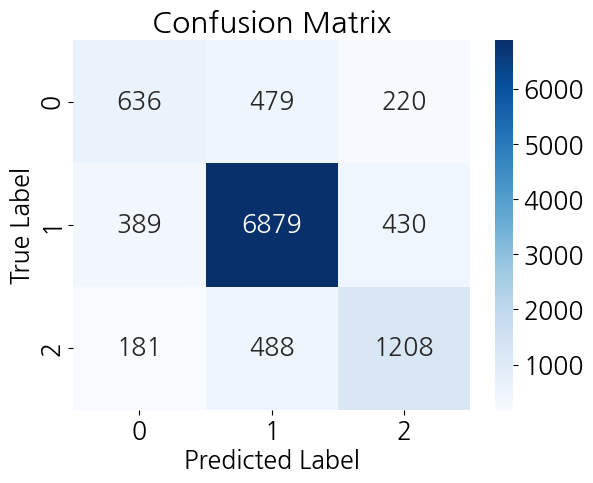

In [ ]:
# RandomForest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
print(y_pred_proba)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

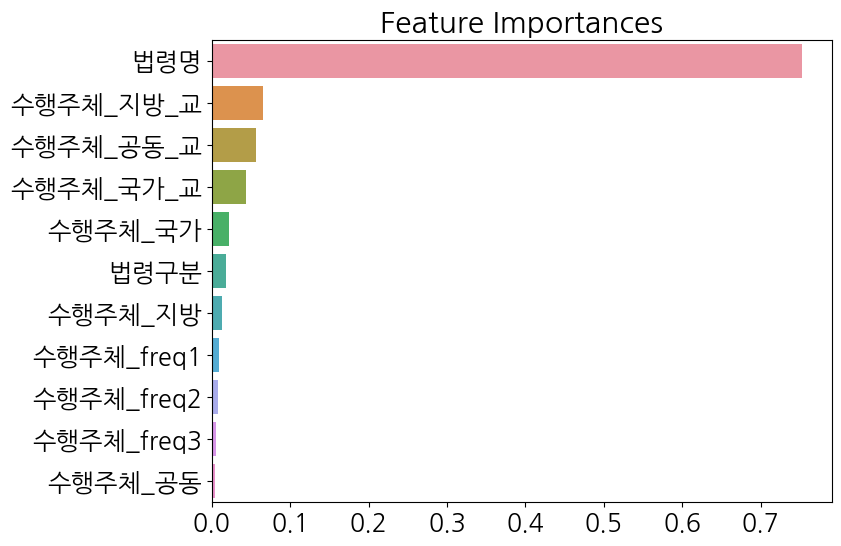

In [ ]:
importance = model.feature_importances_
ser = pd.Series(importance, index = X.columns)

# 가장 중요한 feature 순으로 정렬
importance_sort = ser.sort_values(ascending=False)
plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=importance_sort, y=importance_sort.index)
plt.show()